# Get News Data

In [3]:
import pymongo
import pandas as pd
client = pymongo.MongoClient(host='localhost', port=27017)
# client = MongoClient('mongodb://localhost:27017/')
db = client.covNews
# db = client['covNews']
collection = db['2020_03']

In [4]:
collection.find_one({'published':{'$regex':'2020'}})

{'_id': ObjectId('5ee19be268366fc525129c68'),
 'organizations': [],
 'uuid': '0d6795bf4963c1d5b8fb09c2e6ef632f6acb80e1',
 'thread': {'social': {'gplus': {'shares': 0},
   'pinterest': {'shares': 0},
   'vk': {'shares': 0},
   'linkedin': {'shares': 0},
   'facebook': {'likes': 0, 'shares': 0, 'comments': 0},
   'stumbledupon': {'shares': 0}},
  'site_full': 'www.680news.com',
  'main_image': 'https://www.680news.com/wp-content/blogs.dir/sites/2/2020/03/fng11054947.jpg',
  'site_section': 'http://www.680news.com/category/national/feed/',
  'section_title': 'National – 680 NEWS',
  'url': 'https://www.680news.com/2020/03/29/doug-fords-handling-of-the-pandemic-draws-praise-from-friends-and-foes-2/',
  'country': 'CA',
  'domain_rank': 47710,
  'title': 'Doug Ford’s handling of the pandemic draws praise from friends and foes',
  'performance_score': 0,
  'site': '680news.com',
  'participants_count': 1,
  'title_full': '',
  'spam_score': 0.0,
  'site_type': 'news',
  'published': '2020-03

In [15]:
countries = collection.distinct("thread.country")
countries[:5]

['CA', 'IE', 'IN', 'GB', 'RU']

In [8]:
collection.count_documents({'published':{'$regex':'2020-03-26'}})

14689

In [9]:
collection.count_documents({'published':{'$regex':'2020-03-27'}})

41305

In [20]:
[collection.count_documents({'published':{'$regex':'2020-03-{}'.format(i)}}) for i in range(22,30)]

[132, 359, 640, 2555, 14689, 41305, 50665, 46532]

In [3]:
res = collection.find({'published':{'$regex':'2020-03-29'}},{'published':1,'text':1})

In [4]:
published=[]
text=[]
for i in res:
    published.append(i['published'])
    text.append(i['text'])

In [5]:
df_0329 = pd.DataFrame({'published':published,'text':text})
df_0329 = df_0329.sort_values(by='published').reset_index().iloc[:,1:]
del published, text
df_0329.head()

,published,text
0,2020-03-29T00:00:00.000+03:00,DETROIT - President Donald Trump issued an ord...
1,2020-03-29T00:00:00.000+03:00,https://www.greenwichtime.com/news/coronavirus...
2,2020-03-29T00:00:00.000+03:00,The Silver Bay YMCA Conference and Family Retr...
3,2020-03-29T00:00:00.000+03:00,"By Nicole Walton • 14 hours ago\nMARQUETTE, MI..."
4,2020-03-29T00:00:00.000+03:00,The fractured global response to the coronavir...


In [6]:
df_0329.shape

(46532, 2)

In [8]:
import pickle
with open('df_0329.pickle', 'wb') as handle:
    pickle.dump(df_0329, handle, protocol=pickle.HIGHEST_PROTOCOL)

# NLTK analysis

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from tqdm import tqdm 

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords  # Stopwords corpus
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def processText(text):
    word_tokens = word_tokenize(text)
    filtered_sent = [ps.stem(w) for w in word_tokens if not w in stopwords.words('english')]
#     filtered_sent = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stopwords.words('english')]

    return filtered_sent

def getPos(text):
    word_tokens = word_tokenize(text)
    return nltk.pos_tag(word_tokens)

In [108]:
df_0329.loc[:,'pos'] = df_0329['text'].map(getPos)

'DETROIT - President Donald Trump issued an order Friday that seeks to force General Motors to produce ventilators for coronavirus patients under the Defence Production Act.\nTrump said negotiations with General Motors had been productive, “but our fight against the virus is too urgent to allow the give-and-take of the contracting process to continue to run its normal course.”\nTrump, who had previously been reluctant to use the act to force businesses to contribute to the coronavirus fight, said “GM was wasting time” and that his actions will help ensure the quick production of ventilators that will save American lives.\nGM is among the farthest along of U.S. companies trying to repurpose factories to build ventilators. It is working with Ventec Life Systems, a small Seattle-area ventilator maker, to increase the company\'s production and GM will use its auto electronics plant in Kokomo, Indiana to make the machines.\nExperts say that no matter how many ventilators companies can crank

In [122]:
df_0329['text'][:3].map(getPos)

0    [(DETROIT, NNP), (-, :), (President, NNP), (Do...
1    [(https, NN), (:, :), (//www.greenwichtime.com...
2    [(The, DT), (Silver, NNP), (Bay, NNP), (YMCA, ...
Name: text, dtype: object

In [128]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)
chunked = cp.parse(getPos(df_0329['text'][0]))
chunked.draw()  

In [ ]:
namedEnt = nltk.ne_chunk(getPos(df_0329['text'][0]), binary=True)
namedEnt.draw()

In [11]:
all_hc_words = []
for s in tqdm(df_0329['text']):
    all_hc_words.extend(nltk.word_tokenize(s))
all_words = nltk.FreqDist(all_hc_words)
len(all_hc_words),len(all_words)

100%|███████████████████████████████████████████████████████████████████████████| 46532/46532 [04:58<00:00, 155.70it/s]


(26604971, 310267)

In [12]:
with open('all_hc_words.pickle', 'wb') as handle:
    pickle.dump(all_hc_words, handle)

In [13]:
len(all_hc_words),len(all_words)

(26604971, 310267)

In [14]:
pd.DataFrame(all_words.most_common(50))

,0,1
0,",",1157638
1,the,1111111
2,.,971288
3,to,704722
4,of,565237
5,and,558529
6,in,407493
7,a,403358
8,for,236230
9,that,220261


In [15]:
text_len = [len(i) for i in df_0329['text']]
print('Max vocabs:',np.max(text_len))
print('Mean vocabs:',np.round(np.mean(text_len),3))
print('Median vocabs:',np.median(text_len))
print('Min vocabs:',np.min(text_len))

Max vocabs: 100000
Mean vocabs: 3014.968
Median vocabs: 2138.0
Min vocabs: 1


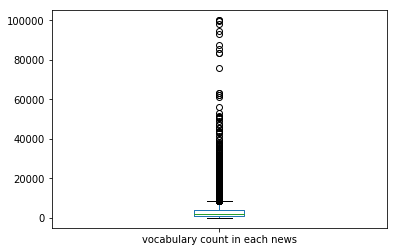

In [138]:
pd.DataFrame(pd.Series(text_len).sort_values().values,columns=['vocabulary count in each news']).plot.box()

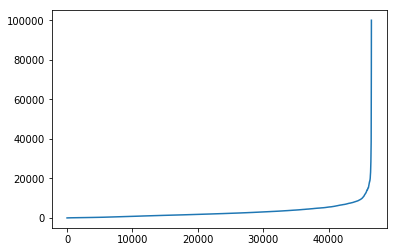

In [139]:
pd.Series(pd.Series(text_len).sort_values().values).plot()

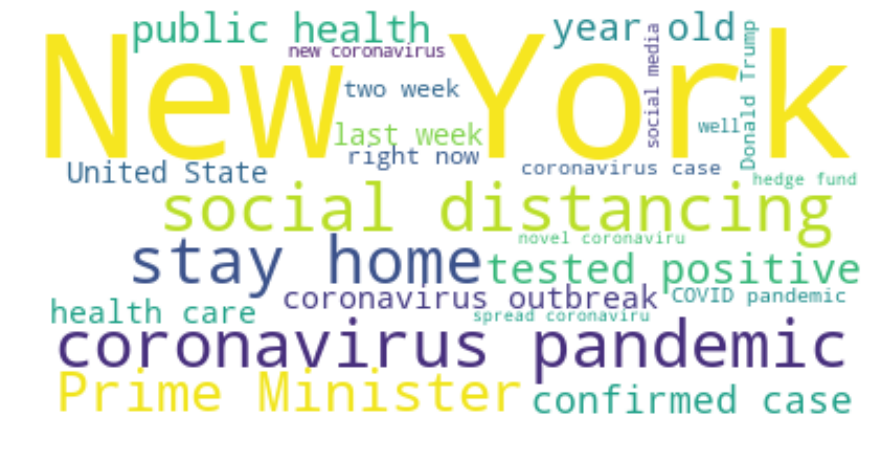

In [140]:
# word cloud
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
# % matplotlib inline

wordcloud = WordCloud(max_font_size=300, min_font_size=8, max_words=50, background_color="white").generate(' '.join(all_hc_words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Topic Modlling

In [ ]:
processedText = df_0329['text'].map(processText) 

In [19]:
processedText = [word_tokenize(i) for i in tqdm(df_0329['text'])]

100%|███████████████████████████████████████████████████████████████████████████| 46532/46532 [06:52<00:00, 112.87it/s]


In [20]:
from gensim import corpora
dictionary = corpora.Dictionary(processedText)
corpus = [dictionary.doc2bow(text) for text in processedText]

In [ ]:
with open('corpus.pickle', 'wb') as handle:
    pickle.dump(corpus, handle)

In [21]:
import gensim
NUM_TOPICS = 8
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

KeyboardInterrupt: 

In [ ]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [18]:
df_0329['text'][:10].map(processText) 

0    [detroit, -, presid, donald, trump, issu, orde...
1    [http, :, //www.greenwichtime.com/news/coronav...
2    [the, silver, bay, ymca, confer, famili, retre...
3    [By, nicol, walton, •, 14, hour, ago, marquett...
4    [the, fractur, global, respons, coronaviru, pa...
5    [tewksburi, —, At, 2, p.m., friday, ,, march, ...
6    [rachel, lapido, ,, march, 28, ,, 2020, photo,...
7    [El, titular, de, la, entidad, ,, alejandro, v...
8    [though, covid-19, pandem, prevent, first, wee...
9    [legal, legal, notic, public, notic, SO, ..., ...
Name: text, dtype: object